In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import load_model
import keras_hub

2025-07-27 13:42:32.292590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753623752.497542      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753623752.558557      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


## Data analysis and visualization

In [ ]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [ ]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
train_df['length'] = train_df['text'].apply(lambda x: len(x))
test_df['length'] = train_df['text'].apply(lambda x: len(x))

In [ ]:
print(f'Train  \n{train_df["length"].describe()}\n')
print(f'Test \n{test_df["length"].describe()}')

Train  
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test 
count    3263.000000
mean      100.581367
std        34.308158
min         7.000000
25%        77.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


<Axes: ylabel='length'>

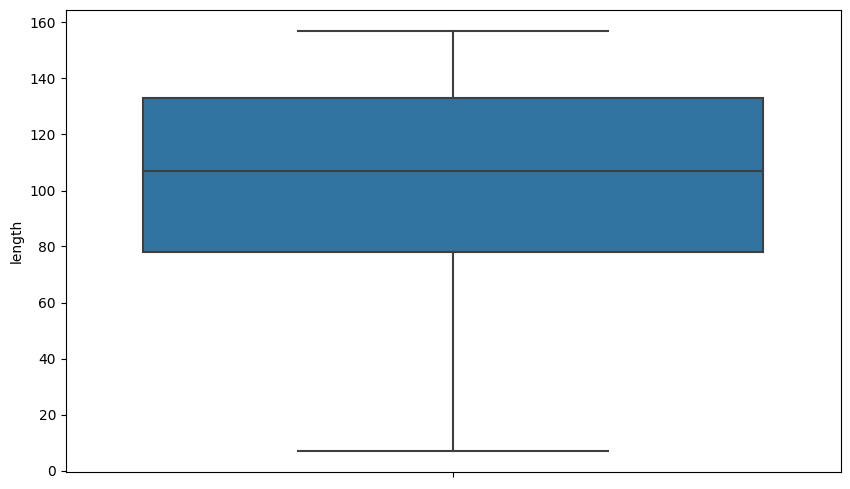

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='length', data=train_df)

In [ ]:
#Filling NaNs
train_df = train_df.fillna('')
test_df = test_df.fillna('')

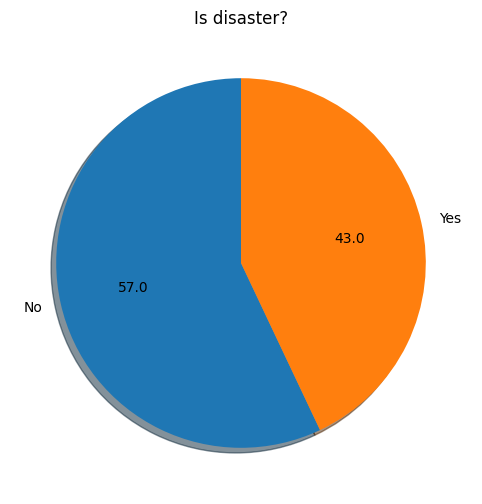

In [ ]:
#Data distribution
plt.figure(figsize=(10, 6))
plt.pie(train_df['target'].value_counts(), labels=["No", "Yes"], startangle=90, shadow=True, autopct='%.1f')
plt.title("Is disaster?")
plt.show()

## Text preprocessing and data augmentation

In [ ]:
def cast_to_dataset(text, label=None):
    '''
    Converts numpy arrays of text (and labels, if provided) into a `tf.data.Dataset` object.

    Args:
        text (np.ndarray): Array of input text strings.
        label (np.ndarray, optional): Array of labels corresponding to each text. Defaults to None.

    Returns:
        tf.data.Dataset: A dataset containing `(text, label)` pairs if `label` is provided,
                         otherwise just `text` elements.
    '''
    # Ensure text is a numpy array; otherwise, we can't use from_tensor_slices directly.
    if isinstance(text, np.ndarray):
        if label is not None:
            # Create dataset of (text, label) pairs
            dataset = tf.data.Dataset.from_tensor_slices((text, label))
        else:
            # Create dataset of text only
            dataset = tf.data.Dataset.from_tensor_slices(text)
    return dataset

In [ ]:
def replace_special_characters(text, label=None):
    """
    Cleans a given text tensor by applying a series of text normalization steps:
        1. Replaces any link with the placeholder [link].
        2. Removes all characters except alphabetic letters, spaces, '!', and '[]'.
        3. Converts all text to lowercase.
        4. Replaces multiple spaces in a row with a single space.

    Args:
        text (tf.Tensor): Input text tensor to be cleaned.
        label (tf.Tensor, optional): Label associated with the text (returned unchanged).

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A tuple of (cleaned text, unchanged label).
    """

    # Replace URLs with a placeholder
    text = tf.strings.regex_replace(text, '(https?://\S+|www\.\S+)', '[link]')
    # Remove non-alphabetic characters except '!', '[', and ']'
    text = tf.strings.regex_replace(text, r'[^a-zA-Z !\[\]]', '')
    # Convert to lowercase
    text = tf.strings.lower(text)
    # Normalize multiple spaces to a single space
    text = tf.strings.regex_replace(text, r'\s{2,}', ' ')

    return text, label

In [ ]:
def make_augment_text(random_swap, random_deletion):
    '''
    Creates a function to apply text data augmentation using RandomSwap and RandomDeletion layers.

    The returned function takes a single `(text, label)` pair, applies both augmentations,
    and returns a dataset containing the original text, swapped version, and deleted version,
    all with the same label.

    Args:
        random_swap (keras_hub.layers.RandomSwap): A layer that randomly swaps tokens.
        random_deletion (keras_hub.layers.RandomDeletion): A layer that randomly deletes tokens.

    Returns:
        Callable: A function that takes `(x, y)` and returns a dataset with three versions of the text.
    '''
    def augment_text(x, y):
        # Tokenize the input text into individual tokens
        tokens = tf.strings.split(x)
        tokens = tf.expand_dims(tokens, axis=0)  # Add batch dimension since layers expect batched input

        # Apply random swapping of tokens
        swapped = random_swap(tokens)
        # Apply random deletion of tokens
        deleted = random_deletion(tokens)

        # Convert tokens back to strings
        swapped_text = tf.strings.reduce_join(swapped, axis=-1, separator=' ')
        deleted_text = tf.strings.reduce_join(deleted, axis=-1, separator=' ')

        # Construct a dataset containing original, swapped, and deleted versions
        ds = tf.data.Dataset.from_tensors((x, y))
        ds = ds.concatenate(tf.data.Dataset.from_tensors((swapped_text[0], y)))
        ds = ds.concatenate(tf.data.Dataset.from_tensors((deleted_text[0], y)))
        return ds
    return augment_text

In [ ]:
def preprocess_dataset(text, batch_size, label=None, augment=False, rs_rate=0.4, rd_rate=0.4, seed=42):
    '''
    Prepares a text dataset for training:
        1. Converts text (and labels) into a `tf.data.Dataset`.
        2. Applies text cleaning (removing special characters, links, etc.).
        3. Optionally applies data augmentation using random swap and random deletion.
        4. Batches, caches, and prefetches the dataset for efficient training.

    Args:
        text (np.ndarray): Array of input text strings.
        batch_size (int): Size of batches to create.
        label (np.ndarray, optional): Array of labels corresponding to text. Defaults to None.
        augment (bool, optional): Whether to apply data augmentation. Defaults to False.
        rs_rate (float, optional): Rate parameter for RandomSwap. Defaults to 0.4.
        rd_rate (float, optional): Rate parameter for RandomDeletion. Defaults to 0.4.
        seed (int, optional): Random seed for augmentation layers. Defaults to 42.

    Returns:
        tf.data.Dataset: A preprocessed (and optionally augmented) dataset ready for training.
    '''

    # Step 1: Create dataset from raw arrays
    processed_d = cast_to_dataset(text, label)

    # Step 2: Apply text cleaning
    processed_d = processed_d.map(replace_special_characters)

    # Step 3: Apply data augmentation if requested
    if augment:
        random_swap = keras_hub.layers.RandomSwap(rate=rs_rate, seed=seed)
        random_deletion = keras_hub.layers.RandomDeletion(rate=rd_rate, seed=seed)
        augment_fn = make_augment_text(random_swap, random_deletion)

        # flat_map expands dataset: each element becomes multiple elements (original + augmented)
        processed_d = processed_d.flat_map(augment_fn)

    # Step 4: Batch, cache, and prefetch for better performance
    if label is not None:
        AUTOTUNE = tf.data.AUTOTUNE
        processed_d = processed_d.batch(batch_size).cache().prefetch(AUTOTUNE)
    return processed_d

In [ ]:
X = train_df['text'].astype(str).values
y = train_df['target'].astype(np.float32).values
X_test = test_df['text'].astype(str).values

In [ ]:
#Splitting dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(f"X_train length: {len(X_train)}\ny_train length : {len(y_train)} \nX_val length: {len(X_val)}\ny_val length: {len(y_val)} ")

X_train length: 6090
y_train length : 6090 
X_val length: 1523
y_val length: 1523 


In [ ]:
prep_train = preprocess_dataset(X_train, 32, y_train, True)
prep_val = preprocess_dataset(X_val, 32, y_val)
prep_test = preprocess_dataset(X_test, 32)

I0000 00:00:1753623768.520088      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
def plot_history(history, title=''):
    '''
    Plots the training and validation loss/accuracy curves from a Keras History object.

    Args:
        history (tf.keras.callbacks.History):
            The history object returned by `model.fit()`.
            It contains metric values (e.g., loss, accuracy) for each epoch.
        title (str, optional):
            A prefix for the subplot titles (e.g., the model name or experiment name).
            Defaults to an empty string.

    Returns:
        None. Displays a matplotlib plot with two subplots:
        - Left: Training and validation loss over epochs.
        - Right: Training and validation accuracy over epochs.
    '''

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # ---- Loss subplot ----
    ax1.plot(history.history['loss'], label='Loss')           # Training loss
    ax1.plot(history.history['val_loss'], label='Val Loss')   # Validation loss
    ax1.set_xlabel('Epochs')                                 # X-axis: epochs
    ax1.set_ylabel('Loss')                                   # Y-axis: loss value
    ax1.grid(True)                                           # Show grid for better readability
    ax1.set_title(title + 'Loss')                            # Title of loss plot
    ax1.legend()                                             # Display legend

    # ---- Accuracy subplot ----
    ax2.plot(history.history['accuracy'], label='Accuracy')        # Training accuracy
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy')# Validation accuracy
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    ax2.set_title(title + 'Accuracy')
    ax2.legend()

    # Adjust spacing between subplots for clarity
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Display the plots
    plt.show()


## Creating DistilBERT model.

In [ ]:
preset= "distil_bert_base_en_uncased"
name = "preprocessor_4_tweets"

def initialize_model(dropout, preset, name, sequence_length, num_classes, freeze_layers=0):
    '''
    Creates a DistilBERT-based classifier model along with its preprocessor.

    Steps:
        1. Loads a DistilBERT preprocessor from the given preset with the specified sequence length.
        2. Loads a DistilBERT classifier (with a classification head) initialized from the same preset.
        3. Applies the specified dropout rate to the classifier.
        4. Optionally freezes the first `freeze_layers` layers of the backbone (useful for fine-tuning).

    Args:
        dropout (float): Dropout rate for the classifier head.
        preset (str): Name of the DistilBERT preset to load (e.g., "distil_bert_base_en_uncased").
        name (str): Name to assign to the preprocessor model/layer.
        sequence_length (int): Maximum number of tokens to consider for each input text.
        num_classes (int): Number of output classes (defines classifier output size).
        freeze_layers (int, optional): Number of initial layers to freeze in the backbone.
                                       Freezes layers up to (freeze_layers - 1). Defaults to 0 (no freezing).

    Returns:
        classifier (tf.keras.Model): A Keras model that includes both the preprocessor and the DistilBERT backbone.
    '''

    # Load the preprocessor that handles tokenization, lowercasing, etc.
    preprocessor = keras_hub.models.DistilBertPreprocessor.from_preset(
        preset,
        sequence_length=sequence_length,
        name=name
    )

    # Load the classifier model from the same preset and attach the preprocessor.
    # The classifier includes a classification head with `num_classes` outputs.
    classifier = keras_hub.models.DistilBertClassifier.from_preset(
        preset,
        num_classes=num_classes,
        preprocessor=preprocessor,
        dropout=dropout
    )

    # Freeze the first `freeze_layers` layers of the backbone (for partial fine-tuning).
    if freeze_layers:
        for layer in classifier.backbone.layers[:freeze_layers]:
            print(layer)  # Print frozen layer for debugging or logging purposes.
            layer.trainable = False  # Disable training for this layer.

    return classifier

In [ ]:
def train_model(model, train, val, lr, callbacks, epochs):
    '''
    Compiles and trains a given TensorFlow/Keras model on the provided datasets.

    Args:
        model (tf.keras.Model): The Keras model to compile and train.
        train (tf.data.Dataset): Training dataset.
        val (tf.data.Dataset): Validation dataset.
        lr (float): Learning rate for the AdamW optimizer.
        callbacks (list): List of Keras callbacks to apply during training (e.g., EarlyStopping, ModelCheckpoint).
        epochs (int): Number of epochs to train the model.

    Returns:
        history (tf.keras.callbacks.History): Training history object containing loss and metrics per epoch.
        model (tf.keras.Model): The trained Keras model.
    '''

    # Compile the model with:
    # - SparseCategoricalCrossentropy loss (with logits, so no softmax in output layer)
    # - AdamW optimizer with specified learning rate
    # - Accuracy metric for evaluation
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.AdamW(lr),
        metrics=['accuracy']
    )

    # Train the model using the train dataset, validate on val dataset,
    # apply callbacks and train for the specified number of epochs
    history = model.fit(
        train,
        callbacks=callbacks,
        epochs=epochs,
        validation_data=val
    )

    return history, model

In [ ]:
checkpoint_path = '/kaggle/working/best_model.weights.h5'
lr = 1e-5
dropout = 0.2
freeze_layers = -3
classifier = initialize_model(dropout, preset, name, sequence_length=157, num_classes=2, freeze_layers=freeze_layers)
classifier.summary()

<InputLayer name=token_ids, built=True>
<TokenAndPositionEmbedding name=token_and_position_embedding, built=True>
<LayerNormalization name=embeddings_layer_norm, built=True>
<Dropout name=embeddings_dropout, built=True>
<InputLayer name=padding_mask, built=True>
<TransformerEncoder name=transformer_layer_0, built=True>
<TransformerEncoder name=transformer_layer_1, built=True>
<TransformerEncoder name=transformer_layer_2, built=True>


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 21,855,746 (83.37 MB)

 Non-trainable params: 45,099,264 (172.04 MB)

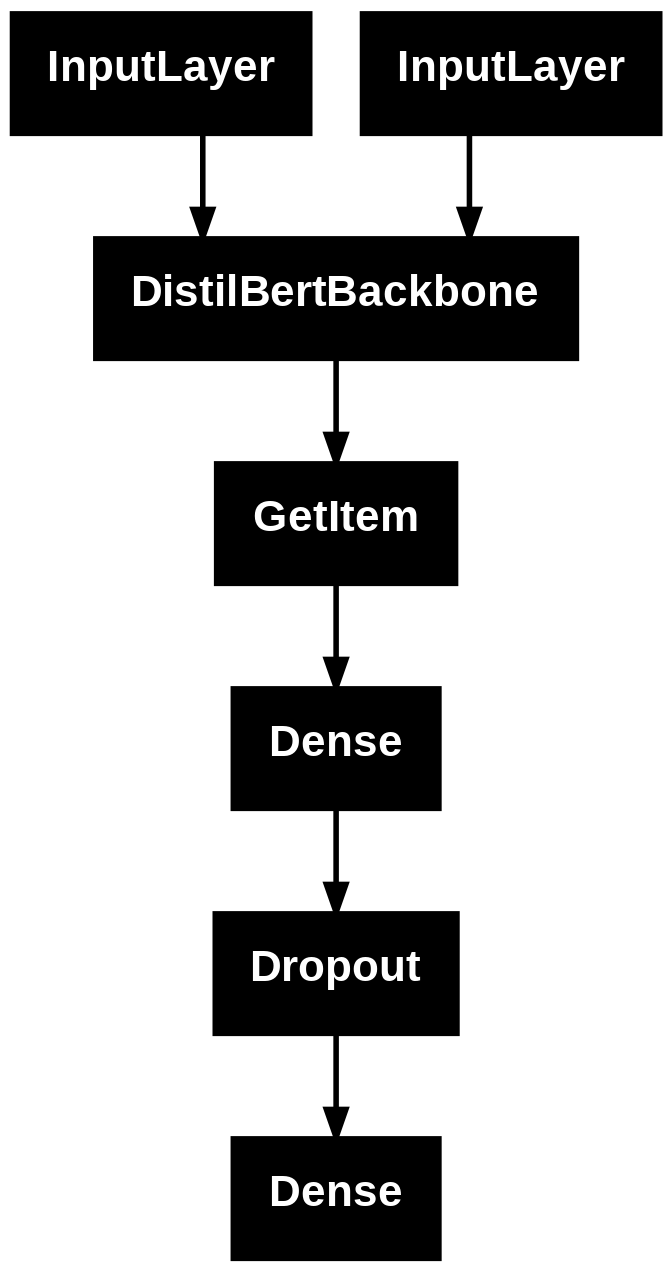

In [ ]:
tf.keras.utils.plot_model(classifier)

In [ ]:
#Initializing callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()
]

Dropout : 0.2
Learning_rate : 1e-05
Frozen layers : -3
Epoch 1/100


I0000 00:00:1753623798.475687      57 service.cc:148] XLA service 0x78b0f000e7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753623798.476316      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753623800.299443      57 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753623812.664253      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    571/Unknown 142s 192ms/step - accuracy: 0.7089 - loss: 0.5546

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


571/571 ━━━━━━━━━━━━━━━━━━━━ 152s 209ms/step - accuracy: 0.7090 - loss: 0.5545 - val_accuracy: 0.8313 - val_loss: 0.4022 - learning_rate: 1.0000e-05
Epoch 2/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 95s 166ms/step - accuracy: 0.8095 - loss: 0.4282 - val_accuracy: 0.8326 - val_loss: 0.3926 - learning_rate: 1.0000e-05
Epoch 3/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 95s 166ms/step - accuracy: 0.8273 - loss: 0.3996 - val_accuracy: 0.8352 - val_loss: 0.3905 - learning_rate: 1.0000e-05
Epoch 4/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 94s 164ms/step - accuracy: 0.8376 - loss: 0.3777 - val_accuracy: 0.8359 - val_loss: 0.3928 - learning_rate: 1.0000e-05
Epoch 5/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 94s 164ms/step - accuracy: 0.8493 - loss: 0.3507 - val_accuracy: 0.8293 - val_loss: 0.4006 - learning_rate: 1.0000e-05
Epoch 6/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 94s 164ms/step - accuracy: 0.8651 - loss: 0.3253 - val_accuracy: 0.8273 - val_loss: 0.4169 - learning_rate: 1.0000e-05
Epoch 7/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 94s 164ms/

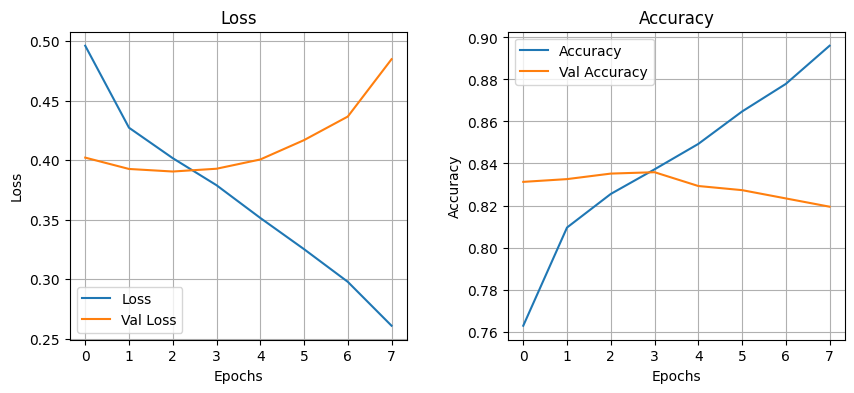

In [ ]:
print(f'Dropout : {dropout}\nLearning_rate : {lr}\nFrozen layers : {freeze_layers}')

history, classifier = train_model(classifier, prep_train, prep_val, lr, callbacks, 100)
plot_history(history)

## Making predictions on train, validation, test datasets and evaluating results

In [ ]:
classifier.load_weights(checkpoint_path)

In [ ]:
def plot_confusion_matrix(y, y_pred, dataset_title):
    '''
    Plots a confusion matrix for the given true and predicted labels.

    Args:
        y (array-like): True labels (ground truth).
        y_pred (array-like): Predicted labels from the model.
        dataset_title (str): Title to display above the confusion matrix.

    Returns:
        None. Displays a matplotlib plot of the confusion matrix.
    '''

    # Compute the confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Create a ConfusionMatrixDisplay object with custom class labels
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['Not disaster', 'Disaster']
    )

    # Plot the confusion matrix using a blue color map
    cm_display.plot(cmap='Blues')

    # Set a title for the plot
    cm_display.ax_.set_title(dataset_title)

    # Display the plot
    plt.show()


In [ ]:
def make_prediction(dataset):
    '''
    Runs predictions on a given dataset using the global `classifier` model.

    Steps:
        1. Extracts only the input features (x) from the dataset.
        2. Concatenates all true labels (y) into a single NumPy array.
        3. Runs the model to get prediction probabilities.
        4. Converts predicted probabilities to class indices using `argmax`.

    Args:
        dataset (tf.data.Dataset): A batched dataset of (text, label) pairs.

    Returns:
        y_true (np.ndarray): True labels from the dataset.
        y_pred (np.ndarray): Predicted class indices.
    '''

    # Extract inputs (x) only, ignoring labels
    ds_x = dataset.map(lambda x, y: x)

    # NOTE: `first = next(iter(prep_test))` appears unused. Likely leftover code.
    first = next(iter(prep_test))  # This line seems unnecessary, consider removing.

    # Concatenate all labels into a single numpy array
    y_true = tf.concat([y for _, y in dataset], axis=0).numpy()

    # Predict probabilities using the classifier model
    y_prob = classifier.predict(ds_x, verbose=0)

    # Convert probabilities to class indices
    y_pred = tf.argmax(y_prob, axis=1).numpy()

    return y_true, y_pred


In [ ]:
def output_predicted_text(target_value, predicted_value, amount=0):
    '''
    Prints examples where the predicted label differs from the true label.

    Steps:
        1. Iterates over true and predicted values (limited by `amount`).
        2. Maps numerical labels (0/1) to text labels ('Not a disaster'/'Disaster').
        3. Prints examples where prediction != target, showing the original text.

    Args:
        target_value (np.ndarray or list): Array of true labels (0/1).
        predicted_value (np.ndarray or list): Array of predicted labels (0/1).
        amount (int, optional): Number of samples to check.
                                If 0, checks the entire dataset.

    Returns:
        None. Prints misclassified samples with their text and labels.
    '''

    index = 0
    for target, pred in zip(target_value[:amount], predicted_value[:amount]):

        # Convert numeric labels to human-readable text
        target = 'Disaster' if target == 1 else 'Not a disaster'
        pred = 'Disaster' if pred == 1 else 'Not a disaster'

        # Print only misclassified examples
        if target != pred:
            print(f'{X_train[index]} Real target: {target} Predicted value : {pred}')

        index += 1


In [ ]:
y_true_train, y_pred_train = make_prediction(prep_train)

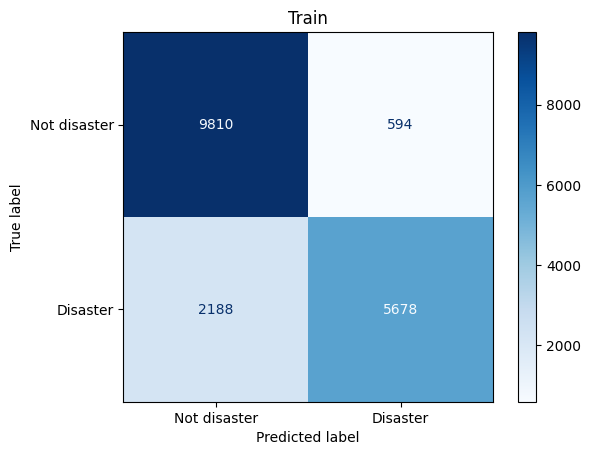

In [ ]:
#Plotting confusion matrix for our train dataset
plot_confusion_matrix(y_true_train, y_pred_train, 'Train')

In [ ]:
#Printing train dataset's misclassified sentances
output_predicted_text(y_true_train, y_pred_train, amount=50)

@billy_hodge Aurora theater shooting trial: Gunman expected notoriety for mass murder and nothing else  http://t.co/1RPCHRu72C Real target: Not a disaster Predicted value : Disaster
Lol The real issue is the the way the NFL is trying to ruin this guy's legacy. https://t.co/s107ee7CYC Real target: Disaster Predicted value : Not a disaster
Maailiss: Diaporama : sixpenceee: Karymsky Lake is a crater lake located in the Karymsky volcanoåÊinåÊRussia. With aÛ_ http://t.co/4o460Fm8HN Real target: Disaster Predicted value : Not a disaster
My biggest fear is disappointing the people who believe in me Real target: Disaster Predicted value : Not a disaster
@CortezEra I dead ass screamed when we signed him I couldn't fucking believe it Real target: Disaster Predicted value : Not a disaster
@Caitsroberts see U the night wee bArra to get absolutely wrecked ???? Real target: Disaster Predicted value : Not a disaster
Mental/Twitter Note: Make sure my smoke alarm battery is up to snuff at all times or

In [ ]:
print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88     10404
         1.0       0.91      0.72      0.80      7866

    accuracy                           0.85     18270
   macro avg       0.86      0.83      0.84     18270
weighted avg       0.86      0.85      0.84     18270



In [ ]:
y_true_val, y_pred_val = make_prediction(prep_val)

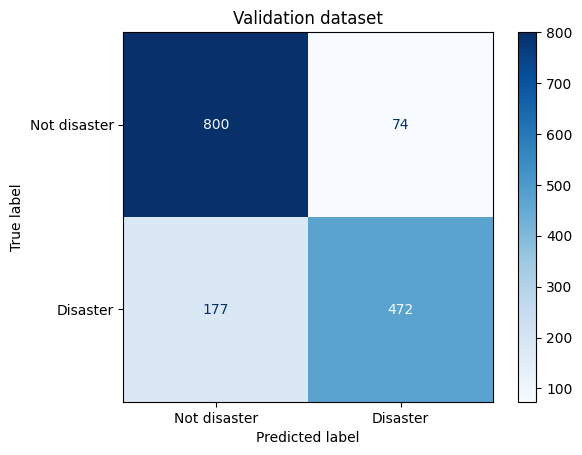

In [ ]:
#Plotting confusion matrix for our val dataset
plot_confusion_matrix(y_true_val, y_pred_val, 'Validation dataset')

In [ ]:
print(classification_report(y_true_val, y_pred_val))

              precision    recall  f1-score   support

         0.0       0.82      0.92      0.86       874
         1.0       0.86      0.73      0.79       649

    accuracy                           0.84      1523
   macro avg       0.84      0.82      0.83      1523
weighted avg       0.84      0.84      0.83      1523



In [ ]:
#Printing val dataset's misclassified sentances
output_predicted_text(y_true_val, y_pred_val, amount=50)

Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. https://t.co/VhmtyTptGR Real target: Disaster Predicted value : Not a disaster
Our builder is having a dental emergency. Which has ruined my plan to emotionally blackmail him this afternoon with my bump. Real target: Disaster Predicted value : Not a disaster
BMX issues Areal Flood Advisory for Shelby [AL] till Aug 5 9:00 PM CDT http://t.co/62OddEkVLi Real target: Disaster Predicted value : Not a disaster
@Zojadelin you literally almost had a head on collision with us today on pilot knob Real target: Not a disaster Predicted value : Disaster
connor franta: damn sirens I hope everyone is okay. 

dan howell: can you PLEASE get MURDERED on ANOTHER STREET Real target: Not a disaster Predicted value : Disaster
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/MatIJwkzbh via @Change Real target: Not a disaster P

In [ ]:
#Making predictions on the test dataset
X_test, _ = replace_special_characters(X_test)
y_pred_test = classifier.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step


In [ ]:
#Printing predictions
for prediction, test in zip(y_pred_test[:50], X_test[:50]):
    prediction = 'Not a disaster' if prediction == 0 else 'Disaster'
    print(f'Text : {test}, Prediction : {prediction}')

Text : b'just happened a terrible car crash', Prediction : Disaster
Text : b'heard about earthquake is different cities stay safe everyone', Prediction : Disaster
Text : b'there is a forest fire at spot pond geese are fleeing across the street i cannot save them all', Prediction : Disaster
Text : b'apocalypse lighting spokane wildfires', Prediction : Disaster
Text : b'typhoon soudelor kills in china and taiwan', Prediction : Disaster
Text : b'were shakingits an earthquake', Prediction : Disaster
Text : b'theyd probably still show more life than arsenal did yesterday eh eh', Prediction : Not a disaster
Text : b'hey! how are you', Prediction : Not a disaster
Text : b'what a nice hat', Prediction : Not a disaster
Text : b'fuck off!', Prediction : Not a disaster
Text : b'no i dont like cold!', Prediction : Not a disaster
Text : b'nooooooooo! dont do that!', Prediction : Not a disaster
Text : b'no dont tell me that!', Prediction : Not a disaster
Text : b'what if!', Prediction : Not a disast